# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/data/data_amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


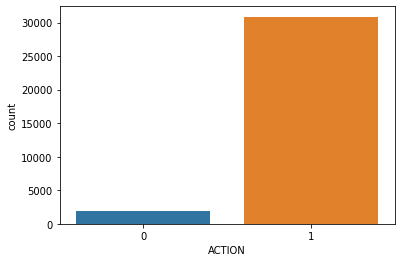

In [4]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [5]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [6]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

In [7]:
X_train

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
26947,79299,17010,117943,117944,117945,117946,231536,292795,117948
29763,35788,16973,117961,118300,124942,117905,117906,290919,117908
28000,25993,13851,117961,118386,118522,307024,306404,118331,118332
11601,43876,72734,118079,118080,117878,117879,117913,19721,117880
1117,20292,56781,117926,118266,117941,118568,195390,19721,118570
...,...,...,...,...,...,...,...,...,...
21575,971,4308,117961,118343,118833,118834,309123,118424,118836
29802,1020,17386,117961,118446,119064,120690,130887,290919,120692
5390,40474,32242,117961,118327,121979,117905,117906,290919,117908
860,25553,66400,117910,117911,117920,123191,123191,19721,123192


# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
%time y_pred = clf.predict(X_test)

CPU times: user 1.07 s, sys: 3.56 ms, total: 1.07 s
Wall time: 1.08 s


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



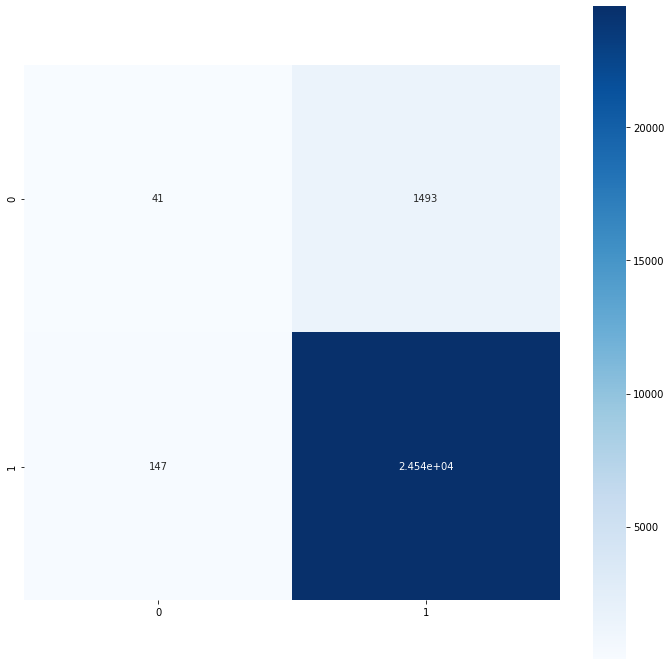

In [11]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

p = str('1,2,4,6').split(',')

for i in range(len(p)):
  clf = KNeighborsClassifier(n_neighbors=10, p=int(p[i]))
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  scores = cross_val_score(clf, X, y, scoring='f1', cv=cv, n_jobs = -1)
  print('p = ', int(p[i]), ' mean = ', scores.mean(), ' std = ', np.std(scores))

p =  1  mean =  0.969142965615208  std =  0.0003324699870669592
p =  2  mean =  0.9687454143288428  std =  0.0005620533013472887
p =  4  mean =  0.9691691437255207  std =  0.0005501576148914798
p =  6  mean =  0.9691566895304126  std =  0.0006951808897963778


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [13]:
X_train['ACTION'] = y_train
X_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ACTION
26947,79299,17010,117943,117944,117945,117946,231536,292795,117948,1
29763,35788,16973,117961,118300,124942,117905,117906,290919,117908,1
28000,25993,13851,117961,118386,118522,307024,306404,118331,118332,0
11601,43876,72734,118079,118080,117878,117879,117913,19721,117880,1
1117,20292,56781,117926,118266,117941,118568,195390,19721,118570,1
...,...,...,...,...,...,...,...,...,...,...
21575,971,4308,117961,118343,118833,118834,309123,118424,118836,1
29802,1020,17386,117961,118446,119064,120690,130887,290919,120692,1
5390,40474,32242,117961,118327,121979,117905,117906,290919,117908,1
860,25553,66400,117910,117911,117920,123191,123191,19721,123192,1


In [14]:
n_folds = 3
fold_size = X_train.shape[0]//n_folds
#X_train.iloc[0:fold_size: 1]

start = 0
end = fold_size
dfs = {}
for i in range(1,  n_folds + 1):
  dfs[i-1] = X_train.iloc[start:end, :]
  start = end
  end += fold_size

In [15]:
len(dfs[0].columns)

10

In [16]:
X_train.shape[0]

6553

In [17]:
df['RESOURCE'].value_counts()

4675     839
79092    484
25993    409
75078    409
3853     404
        ... 
35014      1
75535      1
30936      1
89856      1
16376      1
Name: RESOURCE, Length: 7518, dtype: int64

In [18]:
df[df['ACTION'] == 1].groupby('RESOURCE').size().value_counts()

1      3681
2      1336
3       711
4       364
5       241
       ... 
109       1
81        1
65        1
49        1
283       1
Length: 100, dtype: int64

In [19]:
def smoothed_ratio(counts, successes):
  return (successes + 1) / (counts + 2)

In [20]:
from collections import Counter

train_data = pd.DataFrame(index=df.index)
res_dfs = list()

for i in range(n_folds):
    cur_df = pd.DataFrame()
    calc_df = pd.DataFrame()

    cur_df = cur_df.append(dfs[i])

    for j in range(n_folds):
        if j == i:
            continue
        else:
            calc_df = calc_df.append(dfs[j])
    
    for col_name in cur_df.columns:
        if col_name == 'ACTION':
            continue
        else:
            new_col_name_successe = col_name + '_SUCCESS'
            cur_df['{}_COUNT'.format(col_name)] = [Counter(calc_df[col_name])[x] for x in cur_df[col_name]]
            #cur_df['{}_SUCCESS'.format(col_name)] = [Counter(calc_df['ACTION'] == 1)[x] for x in cur_df[col_name]]
            cur_df['{}_SUCCESS'.format(col_name)] = cur_df[col_name].map(calc_df[calc_df['ACTION'] == 1].groupby(col_name).size())
            cur_df = cur_df.fillna(0)
            cur_df['{}_SMOOTHED_RATIO'.format(col_name)] = cur_df.apply(lambda x: smoothed_ratio(x['{}_COUNT'.format(col_name)], x['{}_SUCCESS'.format(col_name)]), axis = 1)
    
    res_dfs.append(cur_df)

train_data = pd.concat(res_dfs)
train_data

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ACTION,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
26947,79299,17010,117943,117944,117945,117946,231536,292795,117948,1,11,11.0,0.923077,0,0.0,0.500000,15,13.0,0.823529,15,13.0,0.823529,84,71.0,0.837209,44,37.0,0.826087,0,0.0,0.500000,156,136.0,0.867089,44,37.0,0.826087
29763,35788,16973,117961,118300,124942,117905,117906,290919,117908,1,2,2.0,0.750000,6,6.0,0.875000,2810,2674.0,0.951280,591,572.0,0.966273,14,14.0,0.937500,466,455.0,0.974359,922,865.0,0.937229,1466,1384.0,0.943460,466,455.0,0.974359
28000,25993,13851,117961,118386,118522,307024,306404,118331,118332,0,63,60.0,0.938462,3,3.0,0.800000,2810,2674.0,0.951280,236,215.0,0.907563,32,28.0,0.852941,60,57.0,0.935484,15,15.0,0.941176,118,112.0,0.941667,60,57.0,0.935484
11601,43876,72734,118079,118080,117878,117879,117913,19721,117880,1,5,5.0,0.857143,0,0.0,0.500000,22,17.0,0.750000,22,17.0,0.750000,147,140.0,0.946309,164,150.0,0.909639,93,90.0,0.957895,364,338.0,0.926230,164,150.0,0.909639
1117,20292,56781,117926,118266,117941,118568,195390,19721,118570,1,13,13.0,0.933333,1,1.0,0.666667,48,47.0,0.960000,16,16.0,0.944444,109,105.0,0.954955,159,151.0,0.944099,0,0.0,0.500000,364,338.0,0.926230,159,151.0,0.944099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,74226,51372,117961,118343,120666,118777,279443,308574,118779,1,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,512,496.0,0.966926,4,4.0,0.833333,65,62.0,0.940299,88,85.0,0.955556,167,162.0,0.964497,65,62.0,0.940299
21575,971,4308,117961,118343,118833,118834,309123,118424,118836,1,7,7.0,0.888889,6,6.0,0.875000,2818,2674.0,0.948582,512,496.0,0.966926,21,21.0,0.956522,43,42.0,0.955556,8,8.0,0.900000,384,374.0,0.971503,43,42.0,0.955556
29802,1020,17386,117961,118446,119064,120690,130887,290919,120692,1,18,16.0,0.850000,3,3.0,0.800000,2818,2674.0,0.948582,131,128.0,0.969925,18,18.0,0.950000,30,29.0,0.937500,0,0.0,0.500000,1461,1375.0,0.940533,30,29.0,0.937500
5390,40474,32242,117961,118327,121979,117905,117906,290919,117908,1,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,360,345.0,0.955801,4,4.0,0.833333,474,459.0,0.966387,905,846.0,0.933848,1461,1375.0,0.940533,474,459.0,0.966387


In [21]:
train_labels = train_data['ACTION']

In [22]:
train_data

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ACTION,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
26947,79299,17010,117943,117944,117945,117946,231536,292795,117948,1,11,11.0,0.923077,0,0.0,0.500000,15,13.0,0.823529,15,13.0,0.823529,84,71.0,0.837209,44,37.0,0.826087,0,0.0,0.500000,156,136.0,0.867089,44,37.0,0.826087
29763,35788,16973,117961,118300,124942,117905,117906,290919,117908,1,2,2.0,0.750000,6,6.0,0.875000,2810,2674.0,0.951280,591,572.0,0.966273,14,14.0,0.937500,466,455.0,0.974359,922,865.0,0.937229,1466,1384.0,0.943460,466,455.0,0.974359
28000,25993,13851,117961,118386,118522,307024,306404,118331,118332,0,63,60.0,0.938462,3,3.0,0.800000,2810,2674.0,0.951280,236,215.0,0.907563,32,28.0,0.852941,60,57.0,0.935484,15,15.0,0.941176,118,112.0,0.941667,60,57.0,0.935484
11601,43876,72734,118079,118080,117878,117879,117913,19721,117880,1,5,5.0,0.857143,0,0.0,0.500000,22,17.0,0.750000,22,17.0,0.750000,147,140.0,0.946309,164,150.0,0.909639,93,90.0,0.957895,364,338.0,0.926230,164,150.0,0.909639
1117,20292,56781,117926,118266,117941,118568,195390,19721,118570,1,13,13.0,0.933333,1,1.0,0.666667,48,47.0,0.960000,16,16.0,0.944444,109,105.0,0.954955,159,151.0,0.944099,0,0.0,0.500000,364,338.0,0.926230,159,151.0,0.944099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,74226,51372,117961,118343,120666,118777,279443,308574,118779,1,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,512,496.0,0.966926,4,4.0,0.833333,65,62.0,0.940299,88,85.0,0.955556,167,162.0,0.964497,65,62.0,0.940299
21575,971,4308,117961,118343,118833,118834,309123,118424,118836,1,7,7.0,0.888889,6,6.0,0.875000,2818,2674.0,0.948582,512,496.0,0.966926,21,21.0,0.956522,43,42.0,0.955556,8,8.0,0.900000,384,374.0,0.971503,43,42.0,0.955556
29802,1020,17386,117961,118446,119064,120690,130887,290919,120692,1,18,16.0,0.850000,3,3.0,0.800000,2818,2674.0,0.948582,131,128.0,0.969925,18,18.0,0.950000,30,29.0,0.937500,0,0.0,0.500000,1461,1375.0,0.940533,30,29.0,0.937500
5390,40474,32242,117961,118327,121979,117905,117906,290919,117908,1,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,360,345.0,0.955801,4,4.0,0.833333,474,459.0,0.966387,905,846.0,0.933848,1461,1375.0,0.940533,474,459.0,0.966387


In [23]:
train_data = train_data.drop(columns=df.columns)
train_data

,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
26947,11,11.0,0.923077,0,0.0,0.500000,15,13.0,0.823529,15,13.0,0.823529,84,71.0,0.837209,44,37.0,0.826087,0,0.0,0.500000,156,136.0,0.867089,44,37.0,0.826087
29763,2,2.0,0.750000,6,6.0,0.875000,2810,2674.0,0.951280,591,572.0,0.966273,14,14.0,0.937500,466,455.0,0.974359,922,865.0,0.937229,1466,1384.0,0.943460,466,455.0,0.974359
28000,63,60.0,0.938462,3,3.0,0.800000,2810,2674.0,0.951280,236,215.0,0.907563,32,28.0,0.852941,60,57.0,0.935484,15,15.0,0.941176,118,112.0,0.941667,60,57.0,0.935484
11601,5,5.0,0.857143,0,0.0,0.500000,22,17.0,0.750000,22,17.0,0.750000,147,140.0,0.946309,164,150.0,0.909639,93,90.0,0.957895,364,338.0,0.926230,164,150.0,0.909639
1117,13,13.0,0.933333,1,1.0,0.666667,48,47.0,0.960000,16,16.0,0.944444,109,105.0,0.954955,159,151.0,0.944099,0,0.0,0.500000,364,338.0,0.926230,159,151.0,0.944099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,512,496.0,0.966926,4,4.0,0.833333,65,62.0,0.940299,88,85.0,0.955556,167,162.0,0.964497,65,62.0,0.940299
21575,7,7.0,0.888889,6,6.0,0.875000,2818,2674.0,0.948582,512,496.0,0.966926,21,21.0,0.956522,43,42.0,0.955556,8,8.0,0.900000,384,374.0,0.971503,43,42.0,0.955556
29802,18,16.0,0.850000,3,3.0,0.800000,2818,2674.0,0.948582,131,128.0,0.969925,18,18.0,0.950000,30,29.0,0.937500,0,0.0,0.500000,1461,1375.0,0.940533,30,29.0,0.937500
5390,0,0.0,0.500000,0,0.0,0.500000,2818,2674.0,0.948582,360,345.0,0.955801,4,4.0,0.833333,474,459.0,0.966387,905,846.0,0.933848,1461,1375.0,0.940533,474,459.0,0.966387


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [24]:
X_test['ACTION'] = y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
X_test

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ACTION
18245,37793,81744,117902,117903,118783,118451,130134,118453,118454,1
9226,40309,1541,117961,118225,123173,119093,123174,119095,119096,1
27195,27356,205,117961,118386,118746,118784,147114,290919,118786,1
6478,5173,8229,117961,118300,121305,119351,149246,3130,119353,1
4813,77207,51791,117961,119256,120943,118995,280788,292795,118997,1
...,...,...,...,...,...,...,...,...,...,...
16526,89086,5211,118290,118291,119837,118980,261436,118295,118982,1
6771,25993,49453,117961,118343,118660,118912,309291,118424,118914,1
32516,971,4757,118212,118213,118458,119849,290535,118638,119851,1
6992,6977,17713,117961,118225,120663,117905,117906,290919,117908,1


In [30]:
test_data = X_test
test_data

for col_name in X_test.columns:
    if col_name == 'ACTION':
        continue
    else:
        test_data['{}_COUNT'.format(col_name)] = [Counter(test_data[col_name])[x] for x in test_data[col_name]]
        #test_data['{}_SUCCESS'.format(col_name)] = [Counter(X_test['ACTION'] == 1)[x] for x in X_test[col_name]]
        test_data['{}_SUCCESS'.format(col_name)] = test_data[col_name].map(test_data[test_data['ACTION'] == 1].groupby(col_name).size())
        test_data = test_data.fillna(0)
        test_data['{}_SMOOTHED_RATIO'.format(col_name)] = test_data.apply(lambda x: smoothed_ratio(x['{}_COUNT'.format(col_name)], x['{}_SUCCESS'.format(col_name)]), axis = 1)
    
test_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ACTION,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
18245,37793,81744,117902,117903,118783,118451,130134,118453,118454,1,35,30.0,0.837838,8,8.0,0.900000,585,564.0,0.962521,397,387.0,0.972431,296,288.0,0.969799,423,409.0,0.964706,333,323.0,0.967164,760,734,0.964567,423,409.0,0.964706
9226,40309,1541,117961,118225,123173,119093,123174,119095,119096,1,2,2.0,0.750000,30,30.0,0.968750,17190,16319.0,0.949279,2027,1938.0,0.955643,97,95.0,0.969697,172,171.0,0.988506,27,27.0,0.965517,325,321,0.984709,172,171.0,0.988506
27195,27356,205,117961,118386,118746,118784,147114,290919,118786,1,30,30.0,0.968750,39,38.0,0.951220,17190,16319.0,0.949279,1442,1321.0,0.915512,328,311.0,0.945455,1417,1318.0,0.929528,97,94.0,0.959596,8789,8285,0.942555,1417,1318.0,0.929528
6478,5173,8229,117961,118300,121305,119351,149246,3130,119353,1,32,31.0,0.941176,17,17.0,0.947368,17190,16319.0,0.949279,3545,3384.0,0.954328,29,29.0,0.967742,55,54.0,0.964912,4,4.0,0.833333,117,114,0.966387,55,54.0,0.964912
4813,77207,51791,117961,119256,120943,118995,280788,292795,118997,1,2,1.0,0.500000,7,6.0,0.777778,17190,16319.0,0.949279,148,136.0,0.913333,42,39.0,0.909091,159,122.0,0.763975,193,168.0,0.866667,1061,914,0.860771,159,122.0,0.763975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16526,89086,5211,118290,118291,119837,118980,261436,118295,118982,1,1,1.0,0.666667,9,9.0,0.909091,312,276.0,0.882166,311,275.0,0.881789,43,41.0,0.933333,121,112.0,0.918699,9,9.0,0.909091,403,382,0.945679,121,112.0,0.918699
6771,25993,49453,117961,118343,118660,118912,309291,118424,118914,1,329,315.0,0.954683,6,6.0,0.875000,17190,16319.0,0.949279,3183,3090.0,0.970487,100,98.0,0.970588,121,121.0,0.991870,96,96.0,0.989796,2125,2063,0.970381,121,121.0,0.991870
32516,971,4757,118212,118213,118458,119849,290535,118638,119851,1,37,36.0,0.948718,13,13.0,0.933333,308,299.0,0.967742,229,226.0,0.982684,241,232.0,0.958848,267,252.0,0.940520,12,12.0,0.928571,646,607,0.938272,267,252.0,0.940520
6992,6977,17713,117961,118225,120663,117905,117906,290919,117908,1,233,222.0,0.948936,37,37.0,0.974359,17190,16319.0,0.949279,2027,1938.0,0.955643,266,246.0,0.921642,2876,2780.0,0.966296,5523,5152.0,0.932670,8789,8285,0.942555,2876,2780.0,0.966296


In [31]:
test_labels = test_data['ACTION']

In [32]:
test_data = test_data.drop(columns=df.columns)
test_data

,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
18245,35,30.0,0.837838,8,8.0,0.900000,585,564.0,0.962521,397,387.0,0.972431,296,288.0,0.969799,423,409.0,0.964706,333,323.0,0.967164,760,734,0.964567,423,409.0,0.964706
9226,2,2.0,0.750000,30,30.0,0.968750,17190,16319.0,0.949279,2027,1938.0,0.955643,97,95.0,0.969697,172,171.0,0.988506,27,27.0,0.965517,325,321,0.984709,172,171.0,0.988506
27195,30,30.0,0.968750,39,38.0,0.951220,17190,16319.0,0.949279,1442,1321.0,0.915512,328,311.0,0.945455,1417,1318.0,0.929528,97,94.0,0.959596,8789,8285,0.942555,1417,1318.0,0.929528
6478,32,31.0,0.941176,17,17.0,0.947368,17190,16319.0,0.949279,3545,3384.0,0.954328,29,29.0,0.967742,55,54.0,0.964912,4,4.0,0.833333,117,114,0.966387,55,54.0,0.964912
4813,2,1.0,0.500000,7,6.0,0.777778,17190,16319.0,0.949279,148,136.0,0.913333,42,39.0,0.909091,159,122.0,0.763975,193,168.0,0.866667,1061,914,0.860771,159,122.0,0.763975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16526,1,1.0,0.666667,9,9.0,0.909091,312,276.0,0.882166,311,275.0,0.881789,43,41.0,0.933333,121,112.0,0.918699,9,9.0,0.909091,403,382,0.945679,121,112.0,0.918699
6771,329,315.0,0.954683,6,6.0,0.875000,17190,16319.0,0.949279,3183,3090.0,0.970487,100,98.0,0.970588,121,121.0,0.991870,96,96.0,0.989796,2125,2063,0.970381,121,121.0,0.991870
32516,37,36.0,0.948718,13,13.0,0.933333,308,299.0,0.967742,229,226.0,0.982684,241,232.0,0.958848,267,252.0,0.940520,12,12.0,0.928571,646,607,0.938272,267,252.0,0.940520
6992,233,222.0,0.948936,37,37.0,0.974359,17190,16319.0,0.949279,2027,1938.0,0.955643,266,246.0,0.921642,2876,2780.0,0.966296,5523,5152.0,0.932670,8789,8285,0.942555,2876,2780.0,0.966296


In [33]:
train_data.shape

(6552, 27)

In [34]:
train_labels.shape

(6552,)

In [39]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(train_data, train_labels)
%time y_pred = clf.predict(test_data)

CPU times: user 1.37 s, sys: 4 ms, total: 1.37 s
Wall time: 1.37 s


In [40]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1534
           1       0.94      1.00      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.48      0.50      0.48     26216
weighted avg       0.89      0.94      0.91     26216



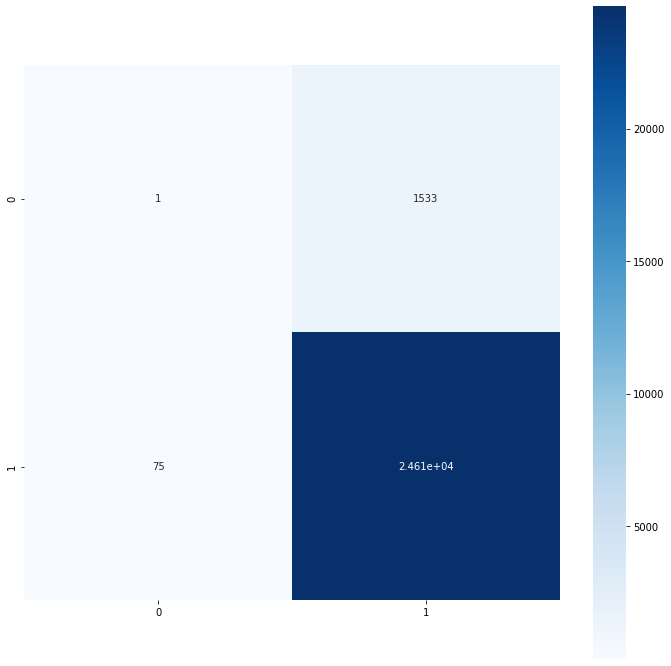

In [41]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

In [43]:
common_df = pd.concat([train_data, test_data])
common_df

,RESOURCE_COUNT,RESOURCE_SUCCESS,RESOURCE_SMOOTHED_RATIO,MGR_ID_COUNT,MGR_ID_SUCCESS,MGR_ID_SMOOTHED_RATIO,ROLE_ROLLUP_1_COUNT,ROLE_ROLLUP_1_SUCCESS,ROLE_ROLLUP_1_SMOOTHED_RATIO,ROLE_ROLLUP_2_COUNT,ROLE_ROLLUP_2_SUCCESS,ROLE_ROLLUP_2_SMOOTHED_RATIO,ROLE_DEPTNAME_COUNT,ROLE_DEPTNAME_SUCCESS,ROLE_DEPTNAME_SMOOTHED_RATIO,ROLE_TITLE_COUNT,ROLE_TITLE_SUCCESS,ROLE_TITLE_SMOOTHED_RATIO,ROLE_FAMILY_DESC_COUNT,ROLE_FAMILY_DESC_SUCCESS,ROLE_FAMILY_DESC_SMOOTHED_RATIO,ROLE_FAMILY_COUNT,ROLE_FAMILY_SUCCESS,ROLE_FAMILY_SMOOTHED_RATIO,ROLE_CODE_COUNT,ROLE_CODE_SUCCESS,ROLE_CODE_SMOOTHED_RATIO
26947,11,11.0,0.923077,0,0.0,0.500000,15,13.0,0.823529,15,13.0,0.823529,84,71.0,0.837209,44,37.0,0.826087,0,0.0,0.500000,156,136.0,0.867089,44,37.0,0.826087
29763,2,2.0,0.750000,6,6.0,0.875000,2810,2674.0,0.951280,591,572.0,0.966273,14,14.0,0.937500,466,455.0,0.974359,922,865.0,0.937229,1466,1384.0,0.943460,466,455.0,0.974359
28000,63,60.0,0.938462,3,3.0,0.800000,2810,2674.0,0.951280,236,215.0,0.907563,32,28.0,0.852941,60,57.0,0.935484,15,15.0,0.941176,118,112.0,0.941667,60,57.0,0.935484
11601,5,5.0,0.857143,0,0.0,0.500000,22,17.0,0.750000,22,17.0,0.750000,147,140.0,0.946309,164,150.0,0.909639,93,90.0,0.957895,364,338.0,0.926230,164,150.0,0.909639
1117,13,13.0,0.933333,1,1.0,0.666667,48,47.0,0.960000,16,16.0,0.944444,109,105.0,0.954955,159,151.0,0.944099,0,0.0,0.500000,364,338.0,0.926230,159,151.0,0.944099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16526,1,1.0,0.666667,9,9.0,0.909091,312,276.0,0.882166,311,275.0,0.881789,43,41.0,0.933333,121,112.0,0.918699,9,9.0,0.909091,403,382.0,0.945679,121,112.0,0.918699
6771,329,315.0,0.954683,6,6.0,0.875000,17190,16319.0,0.949279,3183,3090.0,0.970487,100,98.0,0.970588,121,121.0,0.991870,96,96.0,0.989796,2125,2063.0,0.970381,121,121.0,0.991870
32516,37,36.0,0.948718,13,13.0,0.933333,308,299.0,0.967742,229,226.0,0.982684,241,232.0,0.958848,267,252.0,0.940520,12,12.0,0.928571,646,607.0,0.938272,267,252.0,0.940520
6992,233,222.0,0.948936,37,37.0,0.974359,17190,16319.0,0.949279,2027,1938.0,0.955643,266,246.0,0.921642,2876,2780.0,0.966296,5523,5152.0,0.932670,8789,8285.0,0.942555,2876,2780.0,0.966296


In [44]:
common_labels = pd.concat([train_labels, test_labels])
common_labels

26947    1
29763    1
28000    0
11601    1
1117     1
        ..
16526    1
6771     1
32516    1
6992     1
30186    1
Name: ACTION, Length: 32768, dtype: int64

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

p = str('1,2,4,6').split(',')

for i in range(len(p)):
  clf = KNeighborsClassifier(n_neighbors=10, p=int(p[i]))
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  scores = cross_val_score(clf, common_df, common_labels, scoring='f1', cv=cv, n_jobs = -1)
  print('p = ', int(p[i]), ' mean = ', scores.mean(), ' std = ', np.std(scores))

p =  1  mean =  0.9705132209855629  std =  0.0015803712430565058
p =  2  mean =  0.9697476588200107  std =  0.0016361036550515515
p =  4  mean =  0.9697375757054477  std =  0.0014683186627432276
p =  6  mean =  0.9698355658525448  std =  0.0014362262847532662


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

Исходя из отчета по классификации, увеличилось количество ложноположительных срабатываний. А также видно увеличение средней точности по кроссвалидации на 1 процент. 

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [77]:
def counts(data):
    new = pd.DataFrame(index=data.index)

    for col in data.columns:
        new_col_name_count = col + '_COUNT'
        fe = data.groupby(col).size()
        new[new_col_name_count] = data[col].map(fe)
    return pd.DataFrame(new)

def successes(data):
    new = pd.DataFrame(index=data.index)

    for col in data.columns:
        new_col_name_count = col + '_SUCCESSES'
        
        fe = data[data['ACTION'] == 1].groupby(col).size()
        new[new_col_name_count] = data[col].map(fe)
    return new

def smoothed_ratio(counts, successes):
  return (successes + 1) / (counts + 2)

def smooth(data):
    new = pd.DataFrame(index=data.index)
    
    for col_name in data.columns:
        new_col_name_count = col_name
        new_col_name_successe = col_name
        new_col_name_smoothed_ratio = col_name + '_SMOOTHED_RATIO'
        new[new_col_name_smoothed_ratio] = data.apply(lambda x: smoothed_ratio(x[new_col_name_count], x[new_col_name_successe]), axis = 1)
    return new

In [78]:
df_combo = df.copy()
newdf = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    for col in df_combo.columns:
        if col == 'ACTION' or col == col_name:
            continue
        newdf[col_name + '+' + col] = df[col_name].astype(str) + '+' + df[col].astype(str)
    
df_combo = newdf
df_combo

,RESOURCE+MGR_ID,RESOURCE+ROLE_ROLLUP_1,RESOURCE+ROLE_ROLLUP_2,RESOURCE+ROLE_DEPTNAME,RESOURCE+ROLE_TITLE,RESOURCE+ROLE_FAMILY_DESC,RESOURCE+ROLE_FAMILY,RESOURCE+ROLE_CODE,MGR_ID+RESOURCE,MGR_ID+ROLE_ROLLUP_1,MGR_ID+ROLE_ROLLUP_2,MGR_ID+ROLE_DEPTNAME,MGR_ID+ROLE_TITLE,MGR_ID+ROLE_FAMILY_DESC,MGR_ID+ROLE_FAMILY,MGR_ID+ROLE_CODE,ROLE_ROLLUP_1+RESOURCE,ROLE_ROLLUP_1+MGR_ID,ROLE_ROLLUP_1+ROLE_ROLLUP_2,ROLE_ROLLUP_1+ROLE_DEPTNAME,ROLE_ROLLUP_1+ROLE_TITLE,ROLE_ROLLUP_1+ROLE_FAMILY_DESC,ROLE_ROLLUP_1+ROLE_FAMILY,ROLE_ROLLUP_1+ROLE_CODE,ROLE_ROLLUP_2+RESOURCE,ROLE_ROLLUP_2+MGR_ID,ROLE_ROLLUP_2+ROLE_ROLLUP_1,ROLE_ROLLUP_2+ROLE_DEPTNAME,ROLE_ROLLUP_2+ROLE_TITLE,ROLE_ROLLUP_2+ROLE_FAMILY_DESC,ROLE_ROLLUP_2+ROLE_FAMILY,ROLE_ROLLUP_2+ROLE_CODE,ROLE_DEPTNAME+RESOURCE,ROLE_DEPTNAME+MGR_ID,ROLE_DEPTNAME+ROLE_ROLLUP_1,ROLE_DEPTNAME+ROLE_ROLLUP_2,ROLE_DEPTNAME+ROLE_TITLE,ROLE_DEPTNAME+ROLE_FAMILY_DESC,ROLE_DEPTNAME+ROLE_FAMILY,ROLE_DEPTNAME+ROLE_CODE,ROLE_TITLE+RESOURCE,ROLE_TITLE+MGR_ID,ROLE_TITLE+ROLE_ROLLUP_1,ROLE_TITLE+ROLE_ROLLUP_2,ROLE_TITLE+ROLE_DEPTNAME,ROLE_TITLE+ROLE_FAMILY_DESC,ROLE_TITLE+ROLE_FAMILY,ROLE_TITLE+ROLE_CODE,ROLE_FAMILY_DESC+RESOURCE,ROLE_FAMILY_DESC+MGR_ID,ROLE_FAMILY_DESC+ROLE_ROLLUP_1,ROLE_FAMILY_DESC+ROLE_ROLLUP_2,ROLE_FAMILY_DESC+ROLE_DEPTNAME,ROLE_FAMILY_DESC+ROLE_TITLE,ROLE_FAMILY_DESC+ROLE_FAMILY,ROLE_FAMILY_DESC+ROLE_CODE,ROLE_FAMILY+RESOURCE,ROLE_FAMILY+MGR_ID,ROLE_FAMILY+ROLE_ROLLUP_1,ROLE_FAMILY+ROLE_ROLLUP_2,ROLE_FAMILY+ROLE_DEPTNAME,ROLE_FAMILY+ROLE_TITLE,ROLE_FAMILY+ROLE_FAMILY_DESC,ROLE_FAMILY+ROLE_CODE,ROLE_CODE+RESOURCE,ROLE_CODE+MGR_ID,ROLE_CODE+ROLE_ROLLUP_1,ROLE_CODE+ROLE_ROLLUP_2,ROLE_CODE+ROLE_DEPTNAME,ROLE_CODE+ROLE_TITLE,ROLE_CODE+ROLE_FAMILY_DESC,ROLE_CODE+ROLE_FAMILY
0,39353+85475,39353+117961,39353+118300,39353+123472,39353+117905,39353+117906,39353+290919,39353+117908,85475+39353,85475+117961,85475+118300,85475+123472,85475+117905,85475+117906,85475+290919,85475+117908,117961+39353,117961+85475,117961+118300,117961+123472,117961+117905,117961+117906,117961+290919,117961+117908,118300+39353,118300+85475,118300+117961,118300+123472,118300+117905,118300+117906,118300+290919,118300+117908,123472+39353,123472+85475,123472+117961,123472+118300,123472+117905,123472+117906,123472+290919,123472+117908,117905+39353,117905+85475,117905+117961,117905+118300,117905+123472,117905+117906,117905+290919,117905+117908,117906+39353,117906+85475,117906+117961,117906+118300,117906+123472,117906+117905,117906+290919,117906+117908,290919+39353,290919+85475,290919+117961,290919+118300,290919+123472,290919+117905,290919+117906,290919+117908,117908+39353,117908+85475,117908+117961,117908+118300,117908+123472,117908+117905,117908+117906,117908+290919
1,17183+1540,17183+117961,17183+118343,17183+123125,17183+118536,17183+118536,17183+308574,17183+118539,1540+17183,1540+117961,1540+118343,1540+123125,1540+118536,1540+118536,1540+308574,1540+118539,117961+17183,117961+1540,117961+118343,117961+123125,117961+118536,117961+118536,117961+308574,117961+118539,118343+17183,118343+1540,118343+117961,118343+123125,118343+118536,118343+118536,118343+308574,118343+118539,123125+17183,123125+1540,123125+117961,123125+118343,123125+118536,123125+118536,123125+308574,123125+118539,118536+17183,118536+1540,118536+117961,118536+118343,118536+123125,118536+118536,118536+308574,118536+118539,118536+17183,118536+1540,118536+117961,118536+118343,118536+123125,118536+118536,118536+308574,118536+118539,308574+17183,308574+1540,308574+117961,308574+118343,308574+123125,308574+118536,308574+118536,308574+118539,118539+17183,118539+1540,118539+117961,118539+118343,118539+123125,118539+118536,118539+118536,118539+308574
2,36724+14457,36724+118219,36724+118220,36724+117884,36724+117879,36724+267952,36724+19721,36724+117880,14457+36724,14457+118219,14457+118220,14457+117884,14457+117879,14457+267952,14457+19721,14457+117880,118219+36724,118219+14457,118219+118220,118219+117884,118219+117879,118219+267952,118219+19721,118219+117880,118220+36724,118

In [79]:
df_combo_sm = pd.DataFrame(index=df_combo.index,columns=df_combo.columns)
new_df = pd.DataFrame(index=df_combo.index,columns=df_combo.columns)
df_combo = pd.concat([df['ACTION'], df_combo], axis=1, sort=False)

In [80]:
new_df = pd.concat([counts(df_combo), successes(df_combo)], axis=1, sort=False)
df_combo_sm = smooth(new_df)

In [81]:
df_combo_sm

,ACTION_COUNT_SMOOTHED_RATIO,RESOURCE+MGR_ID_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_ROLLUP_1_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_ROLLUP_2_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_DEPTNAME_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_TITLE_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_FAMILY_DESC_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_FAMILY_COUNT_SMOOTHED_RATIO,RESOURCE+ROLE_CODE_COUNT_SMOOTHED_RATIO,MGR_ID+RESOURCE_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_ROLLUP_1_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_ROLLUP_2_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_DEPTNAME_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_TITLE_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_FAMILY_DESC_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_FAMILY_COUNT_SMOOTHED_RATIO,MGR_ID+ROLE_CODE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+RESOURCE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+MGR_ID_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_ROLLUP_2_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_DEPTNAME_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_TITLE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_FAMILY_DESC_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_FAMILY_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_1+ROLE_CODE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+RESOURCE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+MGR_ID_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_ROLLUP_1_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_DEPTNAME_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_TITLE_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_FAMILY_DESC_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_FAMILY_COUNT_SMOOTHED_RATIO,ROLE_ROLLUP_2+ROLE_CODE_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+RESOURCE_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+MGR_ID_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_ROLLUP_1_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_ROLLUP_2_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_TITLE_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_FAMILY_DESC_COUNT_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_FAMILY_COUNT_SMOOTHED_RATIO,...,ROLE_DEPTNAME+RESOURCE_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+MGR_ID_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_ROLLUP_1_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_ROLLUP_2_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_TITLE_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_FAMILY_DESC_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_FAMILY_SUCCESSES_SMOOTHED_RATIO,ROLE_DEPTNAME+ROLE_CODE_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+RESOURCE_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+MGR_ID_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_ROLLUP_1_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_ROLLUP_2_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_DEPTNAME_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_FAMILY_DESC_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_FAMILY_SUCCESSES_SMOOTHED_RATIO,ROLE_TITLE+ROLE_CODE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+RESOURCE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+MGR_ID_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_ROLLUP_1_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_ROLLUP_2_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_DEPTNAME_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_TITLE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_FAMILY_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY_DESC+ROLE_CODE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+RESOURCE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+MGR_ID_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_ROLLUP_1_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_ROLLUP_2_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_DEPTNAME_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_TITLE_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_FAMILY_DESC_SUCCESSES_SMOOTHED_RATIO,ROLE_FAMILY+ROLE_CODE_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+RESOURCE_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+MGR_ID_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_ROLLUP_1_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_ROLLUP_2_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_DEPTNAME_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_TITLE_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_FAMILY_DESC_SUCCESSES_SMOOTHED_RATIO,ROLE_CODE+ROLE_FAMILY_SUCCESSES_SMOOTHED_RATIO
0,0.999968,0.800000,0.800000,0.800000,0.666667,0.750000,0.800000,0.800000,0.750000,0.800000,0.982456,0.982456,0.937500,0.937500,0.975000,0.977778,0.937500,0.800000,0.982456,0.999774,0.985294,0.999658,0.999831,0.999894,0.999658,0.800000,0.

In [82]:
data = pd.concat([new_df, df_combo_sm], axis=1, sort=False)

In [83]:
data = data.drop(['ACTION_COUNT_SMOOTHED_RATIO', 'ACTION_COUNT', 'ACTION_SUCCESSES'], axis=1)

In [84]:
data = data.fillna(0)

In [85]:
data = pd.concat([df['ACTION'], data], axis=1, sort=False)

In [86]:
X = data.drop(['ACTION'], axis=1)
y = data['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

clf = KNeighborsClassifier(n_neighbors=3, p=2)
clf.fit(X_train, y_train) 
%time y_pred = clf.predict(X_test)

CPU times: user 9.24 s, sys: 63.9 ms, total: 9.3 s
Wall time: 9.31 s


In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.20      0.28      1534
           1       0.95      0.98      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.70      0.59      0.62     26216
weighted avg       0.92      0.94      0.93     26216



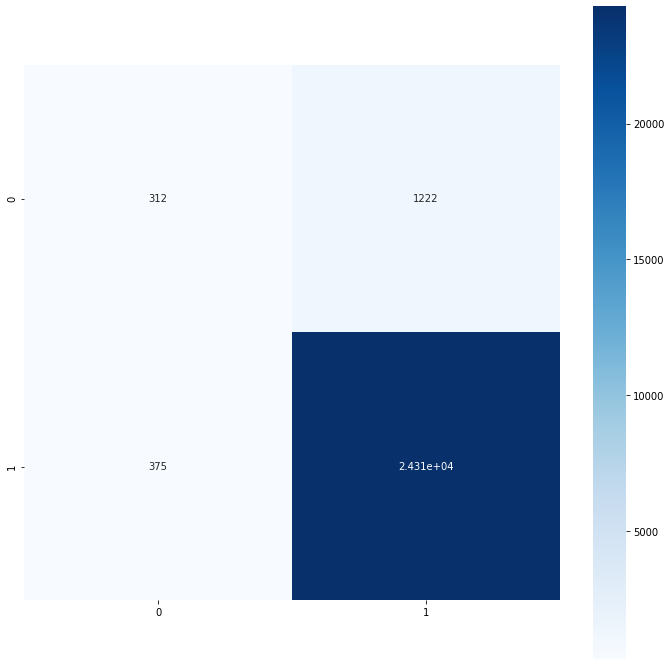

In [88]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [89]:
df_target = df.copy()

In [90]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    df_target[col_name] = df_target[col_name].map(df_target.groupby(col_name)['ACTION'].mean())

In [91]:
XTarg = df_target.drop(['ACTION'], axis=1)
yTarg = df_target['ACTION']
X_train, X_test, y_train, y_test = train_test_split(XTarg, yTarg, random_state=42, test_size=0.8)

In [92]:
clf = KNeighborsClassifier(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
%time y_pred = clf.predict(X_test)

CPU times: user 1.23 s, sys: 2 ms, total: 1.23 s
Wall time: 1.23 s


In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.62      0.69      1534
           1       0.98      0.99      0.98     24682

    accuracy                           0.97     26216
   macro avg       0.87      0.80      0.83     26216
weighted avg       0.96      0.97      0.97     26216



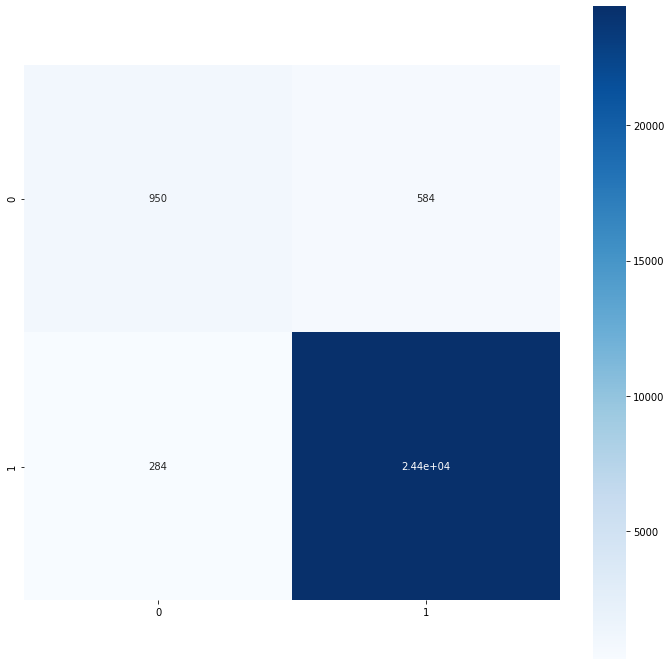

In [94]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Сравните результаты. 

Какой недостаток есть у target encoding?



Проблема целевого кодирования имеет название: чрезмерная подгонка. Действительно, полагаться на среднее значение не всегда хорошая идея, когда число значений, используемых в среднем, невелико. Необходимо иметь в виду, что набор данных, на котором тренируется алгоритм, является образцом большего набора. Это означает, что любые артефакты, которые алгоритм может найти в обучающем наборе, могут оказаться неверными при применении к другому набору данных (то есть тестовому набору).